# Assignment 4: Word Embedding Network
In this assignment you will practice how to create a Word Embedding Network in PyTorch. First, you will finish some functions to parse the data, build the corpus and construct the skip pair. Then, you will construct a word embedding network by follow the specific requirements and architectures. Finally, you will train the network and visualize the result.

You will need to add or change code in any code block marked 'TODO'. Do not change code in the other sections as it may break the notebook.

In [142]:
# Imports for PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Imports for Plotting and Analysis
from collections import Counter
import math
import numpy as np
from sklearn import decomposition
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

# Preprocessing

## TODO: Data selection and Variables (10)
There are two tasks in this section
1. Please input your SUID number in the variable 'SUID'. This will be used as a unique random variable seed for your assignment.
2. Select the text you will be using for training your model. You can select between either a short text or a longer text by setting the variable to True and the others to False. It is recommended that you do all of your testing with the short text.
    - test_doc_short: Small dataset. You can use it to debug your code.
    - test_doc_long: Large dataet. You should use it to get the final result. Make sure to reduce the number of epochs your run when using this text!

In [143]:
# Start TODO
SUID = 231022915
input_text_short = False
input_text_long = True

embedding_size = 10
epochs = 250
batch_size = 128
# End TODO

In [144]:
# Do NOT edit this block!
torch.manual_seed(SUID)

if (input_text_short and input_text_long) or (not input_text_short and not input_text_long):
    raise ValueError('Only one text should be set to True.')

## split_sentence
1. Remove the special characters from the sentence
2. Filter the short sentence

You can rewrite this function or add more filter conditions, but you will not be graded on this section.

In [145]:
def split_sentence(sentences, ignore_short=True):
    new_sentence = list()
    for sentence in sentences:
        sentence = sentence.replace("\n", " ")
        sentence = sentence.replace(",", "")
        sentence = sentence.replace("\'", " ")
        sentence = sentence.replace("\"", " ")
        sentence = sentence.replace("?", "")
        sentence = sentence.replace("!", "")
        sentence = sentence.replace(";", "")
        sentence = sentence.lower()
        if (sentence.count(" ") <= 3) and ignore_short:
            continue
        new_sentence.append(sentence)
    return new_sentence

In [146]:
# This block loads the source text for your model.
file = None
if input_text_short:
    file = open("test_doc_short.txt",'r')
if input_text_long:
    file = open("txt_alice.txt",'r')
raw_data_1 = file.read()
file.close()
sentences = raw_data_1.split(".")

corpus_raw = split_sentence(sentences, ignore_short=False)
counter = Counter(" ".join(corpus_raw).split())
print(counter.most_common(50))

[('is', 6), ('the', 6), ('royal', 4), ('king', 3), ('queen', 3), ('he', 2), ('she', 2)]


# TODO: build_dictionary (10 points)
There are two steps here:
1. Extract the words from the input sentence(s). 
2. Build a non-duplicate word dictionary. For this step we can take advantage of Python's 'set' class. It is already included on the return statement.

Expected Outputs:
- The number of words in "test_doc_short" dataset is 7.
- The number of words in "test_doc_long" dataset is ~1616.

If your number of words is one larger than expected (e.g. 8 for 'test_doc_short'), check to see if you're including ''. If so, you'll want to remove it.

In [147]:
def build_dictionary(corpus_raw):
    words = []
    # TODO
    # for each sentence in the document, split into words and add to list.
    for i in corpus_raw:
        words.extend(i.split())
    # END TODO
    return list(set(words))

corpus_dict = build_dictionary(corpus_raw)
print(len(corpus_dict))
corpus = corpus_raw

7


# TODO: one_hot_encoding (10 points)
This function is used to create the one-hot vectors used as inputs for our network.
1. Every word is represented as a PyTorch tensor containing 1 at its position in the vocabulary.
2. The datatype of the tensor should be 'torch.float'.

In [148]:
def one_hot_encoding(data_point_index, vocab_size):
    # TO DO
    # make temp all zeros of size vocab size, except at the data point index
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    # END TO DO
    return temp

## TODO: build_word_index_mapping (10 points)
This function will return two (2) dictionaries. Respectively, the dictionaries will:
1. Given a word, the function should return the index of this word in dictionary.
2. Given an index, the function should retrieve the word.

In [149]:
def build_word_index_mapping(corpus_dict):   
    word_2_ind = dict()
    ind_2_word = dict()
    # TODO
    # save the index or the word to the corresponding dictioneries
    c = corpus_dict
    for i in range(len(c)):
        word_2_ind[c[i]] = i
        ind_2_word[i] = c[i]
    # END TODO
    return word_2_ind, ind_2_word

In [150]:
word_2_ind, ind_2_word = build_word_index_mapping(corpus_dict)

## TODO: build_skip_pair (10 points)
In this section you will define build_skip_pair. This function will create pairs of a word and its surrounding words. For Example:

    Example Input: 'He is the king .'
    Example Output: [['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'] ... ]

In this assignment, we will use a window size of 2 (so you will have a pair for each word within 2 (inclusive) of the target word). 

In [151]:
WINDOW_SIZE = 2

def build_skip_pair(window_size, sentences):
    data = []
    # TO DO
    # split sentence into words, loop through the list and add the pairs to list
    for s in sentences:
        temp = s.split()
        for i in range(0,len(temp)):
            for j in range(1,window_size+1):
                # a word and all the words to the right side of it
                if(i+j<len(temp)):
                    t = [temp[i],temp[i+j]]
                    data.append(t)
                # a word and all the words to the left side of it
                if(i-j>=0):
                    t = [temp[i],temp[i-j]]
                    data.append(t)

    # END TO DO
    return data

In [152]:
data = build_skip_pair(WINDOW_SIZE, corpus_raw)
print (len(data))
print (data[:5])

68
[['he', 'is'], ['he', 'the'], ['is', 'the'], ['is', 'he'], ['is', 'king']]


## build_train_data_label
1. Iterate all the word pairs in data
2. Construct the train and label data

Preprocess the dataset with batch size given in the setup section.

In [153]:
def build_train_data_label(data, word_2_ind, vocab_size):
    x_train = []
    y_train = []
    input_label_tensor_list = []
    
    for data_word in data:    
        x = one_hot_encoding(word_2_ind[ data_word[0] ], vocab_size)
        x_train.append(x)
        y = one_hot_encoding(word_2_ind[ data_word[1] ], vocab_size)
        y = word_2_ind[ data_word[1] ]
        y_train.append(y)
        y_torch = torch.as_tensor(word_2_ind[data_word[1]])
        input_label_tensor_list.append([x, y])
    return x_train, y_train, input_label_tensor_list

x_train, y_train, input_label_tensor_list = build_train_data_label(data, word_2_ind, len(corpus_dict))

class Custom_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, _dataset):
        self.dataset = _dataset

    def __getitem__(self, index):
        example, target = self.dataset[index]
        return np.array(example), target

    def __len__(self):
        return len(self.dataset)
    
train_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(input_label_tensor_list),
                                           batch_size=batch_size,
                                           shuffle=True)

In [154]:
vocab_size = len(corpus_dict)

# Embedding Network

## TODO: Net (10 points)
In this section you will define your network using two functions.
1. init: Define all the layers you will use in the embedding network.
    The network should have two layers, neither should have a bias.
    - The first layer, called fc1, should have an input size equal to the vocabulary size and output size equal to the embedding size
    - The second layer, called fc2, should have an input size equal to the embedding size and output size equal to the vocabulary size
2. forward: Define the network layer connectivity.
    - Connect the layers together as defined above, with a log_softmax after the second layer.

Finally, you will select a suitable embedding size for your network. This is up to you, so try a few values to see what works.

In [155]:
# Create our Network
class Net(nn.Module):
    # Define layers in the __init__ fuction
    def __init__(self, embedding_size, vocab_size):
        super(Net, self).__init__()
        # TODO
        # linear layers with no bias
        self.fc1 = nn.Linear(vocab_size, embedding_size, bias = False)
        self.fc2 = nn.Linear(embedding_size, vocab_size, bias = False)
        # END TODO

    # Define connectivity in the forward function
    def forward(self, x):
        # TODO
        # connect the layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x)
        # END TODO
        return x
    
# TODO
embedding_size = 5
# END TODO
    

In [156]:
# This section initializes a copy of your network, then assigns it to the correct device
net = Net(embedding_size, vocab_size)
# Select device and output network structure
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (fc1): Linear(in_features=7, out_features=5, bias=False)
  (fc2): Linear(in_features=5, out_features=7, bias=False)
)

## TODO: Optimizer and Criterion (10 points)
In this section you will define your loss function and how you will update your weights.
1. For the criterion use either Cross Entropy Loss or negative log likelihood loss
2. For the optimizer use stochastic gradient descent. Select a learning rate and momentum such that the loss of your model converges.

In [157]:
# TODO
# setting up criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# END TODO

In [158]:
FC1_List = []
FC2_List = []

## TODO: Learning (10 points)
In this section you will start learning your embedding. The steps to do so will be
1. Zero the parameter gradients
2. Do a forward pass to generate and output
3. Calculate the loss based on that output
4. Backpropagate the loss
5. Update your weights.

In [159]:
print("Start Training")
current_time_slice = 0
lowest_loss = math.inf
lowest_loss_slice = -1
for epoch in range(epochs):
    for x,y in train_loader:
        x.to(device)
        y.to(device)
        # TODO        
        
        # flatten the input
        x = x.view(x.shape[0], -1)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(x.float())
        
        # Calculate loss (name your variable 'loss')
        loss = criterion(outputs, y)
        
        # Propagate loss
        loss.backward()

        # Update Weights
        optimizer.step()

        
        # END TODO

    if epoch % 25 == 0:
        print('Epoch {epoch}/Time Slice {current_time_slice}: current loss = {loss}'.format(epoch=epoch, current_time_slice=current_time_slice, loss=loss))
        FC1_List.append(net.fc1.weight.data.clone().detach().cpu().numpy().T)
        FC2_List.append(net.fc2.weight.data.clone().detach().cpu().numpy())
        if loss < lowest_loss:
            lowest_loss = loss
            lowest_loss_slice = current_time_slice
        current_time_slice += 1
    
print('End Training')

Start Training
Epoch 0/Time Slice 0: current loss = 1.9289016723632812
Epoch 25/Time Slice 1: current loss = 1.9224739074707031
Epoch 50/Time Slice 2: current loss = 1.912169337272644
Epoch 75/Time Slice 3: current loss = 1.9000239372253418
Epoch 100/Time Slice 4: current loss = 1.8858555555343628
Epoch 125/Time Slice 5: current loss = 1.8695725202560425
Epoch 150/Time Slice 6: current loss = 1.8513468503952026
Epoch 175/Time Slice 7: current loss = 1.8312857151031494


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 200/Time Slice 8: current loss = 1.8096364736557007
Epoch 225/Time Slice 9: current loss = 1.7865207195281982
End Training


# Analysis
This section will provide some automatic analysis for the network you just made.

## TODO: nearest_indices (10 points)
This function returns the indicies of the closest words. To do this the length has already been calculated. To finish the function 
1. Return the indicies of the closest <search_depth> words.

In [160]:
def nearest_indices(embedded_input, embedding_matrix, search_depth = 3):
    # euclidean_distance is a list of the distances from the current index to all others (one will be zero)
    euclidean_distance = np.linalg.norm(embedded_input - embedding_matrix, axis = 1)    
    nearest_index_list = []
    # TODO
    # sort the euclidean distance and save the number of indexes up to the search depth in the list
    nearest_index_list = euclidean_distance.argsort()[:6]
    
    # END TODO
    
    return nearest_index_list

In [161]:
def print_nearest_words(net, test_words, word_2_ind, ind_2_word, search_depth = 3):    
    net.eval()
    embedded_matrix = net.fc1.weight.data.detach().cpu().numpy().T    
    nearest_words_dict_1 = {}
    print('First Layer Embeddings:')
    for word in test_words:        
        embedded_input = embedded_matrix[word_2_ind[word], :]  
        nearest_words_list = nearest_indices(embedded_input, embedded_matrix, search_depth = search_depth)
        print("Closest Words to Test Word ({word}): {nearest_words_list}".format(word=word, nearest_words_list=list(ind_2_word[i] for i in nearest_words_list)))     
    embedded_matrix = net.fc2.weight.data.detach().cpu().numpy()    
    nearest_words_dict_2 = {}
    print('Second Layer Embeddings:')
    for word in test_words:        
        embedded_input = embedded_matrix[word_2_ind[word], :]  
        nearest_words_list = nearest_indices(embedded_input, embedded_matrix, search_depth = search_depth)
        print("Closest Words to Test Word ({word}): {nearest_words_list}".format(word=word, nearest_words_list=list(ind_2_word[i] for i in nearest_words_list)))

print_nearest_words(net, ['she', 'queen'], word_2_ind, ind_2_word, search_depth=3)

First Layer Embeddings:
Closest Words to Test Word (she): ['she', 'the', 'he', 'queen', 'king', 'is']
Closest Words to Test Word (queen): ['queen', 'he', 'she', 'the', 'is', 'king']
Second Layer Embeddings:
Closest Words to Test Word (she): ['she', 'he', 'king', 'royal', 'queen', 'the']
Closest Words to Test Word (queen): ['queen', 'king', 'he', 'she', 'the', 'royal']


## Plotting
This section will plot the relationship between some of the embeddings. This visual representation may help understanding what the network is doing.

In [162]:
print("The lowest loss ({lowest_loss}) occured at time slice {lowest_loss_slice}".format(lowest_loss=lowest_loss, lowest_loss_slice=lowest_loss_slice))

The lowest loss (1.7865207195281982) occured at time slice 9


This code block extracts the weights of the fully connected layers.

In [163]:
FC1_plot = net.fc1.weight.data.detach().cpu().numpy().T
FC2_plot = net.fc2.weight.data.detach().cpu().numpy()

The following section will plot the weights of the fully connected layers. In order to achieve this, the matrices representing the weights are factorized via singular value decomposition. More information can be found [here](https://en.wikipedia.org/wiki/Singular_value_decomposition).

This section plots the weights of the first layer when the lowest loss is achieved.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


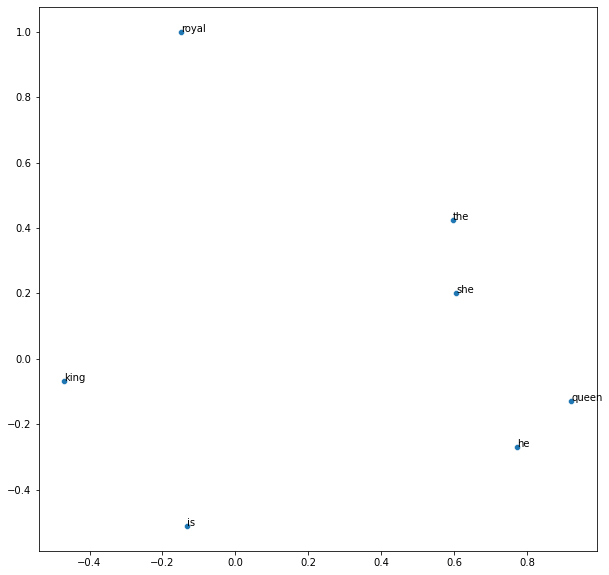

In [164]:
FC1_decompose = decomposition.TruncatedSVD(n_components=2).fit_transform(FC1_plot)
x = FC1_decompose[:,0]
y = FC1_decompose[:,1]
plot = sns.scatterplot(x, y)

for i in range(0, min(FC1_decompose.shape[0], 20)):
     plot.text(x[i], y[i], list(corpus_dict)[i]);

This section plots the weights of the second layer at the end of training.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


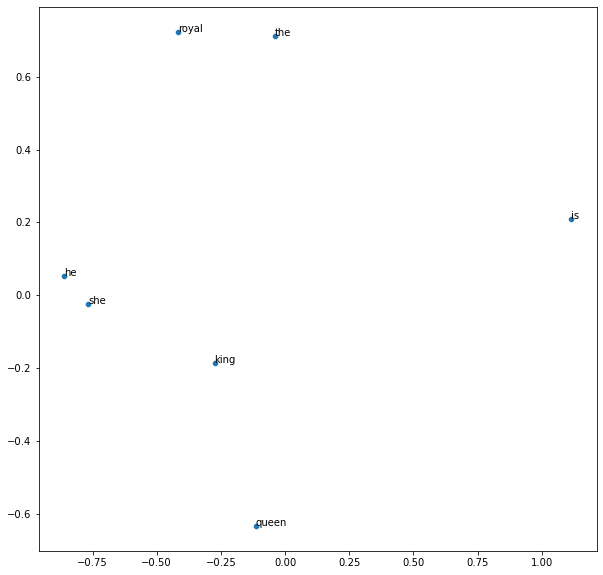

In [165]:
FC2_decompose = decomposition.TruncatedSVD(n_components=2).fit_transform(FC2_plot)
x = FC2_decompose[:,0]
y = FC2_decompose[:,1]
plot = sns.scatterplot(x, y)

for i in range(0, min(FC2_decompose.shape[0], 20)):
     plot.text(x[i], y[i], list(corpus_dict)[i]);

This section plots the weights of the first layer when the lowest loss is achieved.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


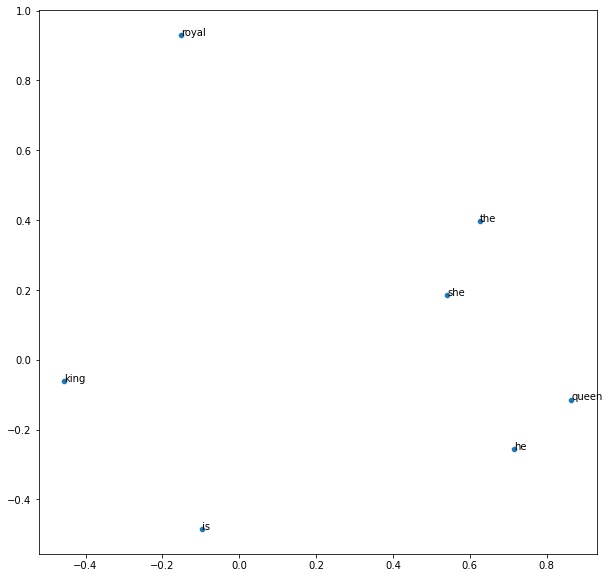

In [166]:
FC1_decompose = decomposition.TruncatedSVD(n_components=2).fit_transform(FC1_List[lowest_loss_slice])
x = FC1_decompose[:,0]
y = FC1_decompose[:,1]
plot = sns.scatterplot(x, y)

for i in range(0, min(FC1_decompose.shape[0], 50)): 
    plot.text(x[i], y[i], list(corpus_dict)[i]);

This section plots the weights of the second layer when the lowest loss is achieved.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


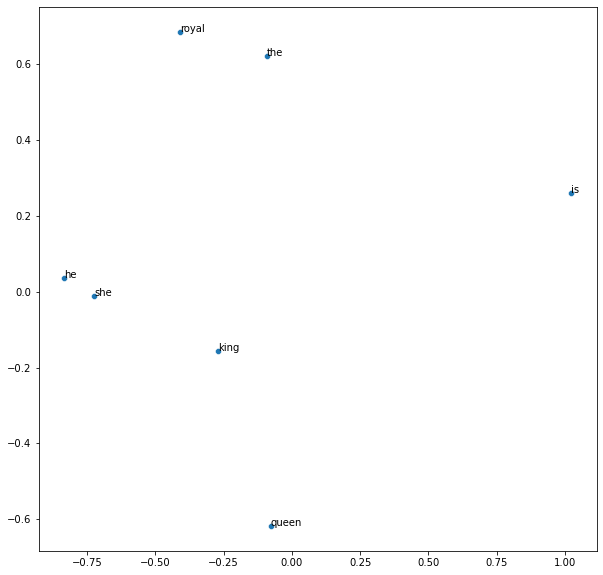

In [167]:
FC2_decompose = decomposition.TruncatedSVD(n_components=2).fit_transform(FC2_List[lowest_loss_slice])
if FC2_decompose.shape[0] < 50:
    x = FC2_decompose[:,0]
    y = FC2_decompose[:,1]
else:
    x = FC2_decompose[:50,0]
    y = FC2_decompose[:50,1]
plot = sns.scatterplot(x, y)

for i in range(0, min(FC2_decompose.shape[0], 50)):
     plot.text(x[i], y[i], list(corpus_dict)[i]);